# Exercise 5: Machine Translation

This session is based on lecture 10 (Machine Translation).

Relevant SLP chapters:
* Chapter 13
* Chapter 10.2 on sampling
* Also good to refresh on the Transformer: Chapter 9 and Exercise 2

## Exercise: Decoding strategies
As discussed in the slides and in the book, neural machine translation generally works using a sequence-to-sequence architecture.
This is mostly modeled as an encoder and a decoder: a component that creates an embedding of the input tokens, which is then decoded by the decoder component into target tokens.
At every timestep during the decoding, the decoder generates a probability distribution over its vocabulary.
In other words, what is the most likely token, given the previous tokens in previous timesteps.
There are a lot of choices regarding *how* we handle the output of the decoder:

* Do we always pick the token with the highest probability?
* Do we do keep alternative options in mind?
* Which and how many hypotheses do we keep in mind?
* What about memory and efficiency (time) considerations?

These types of questions are related to the general problems of *sampling* and *decoding*.
This is a fundamental aspect in dealing with (generative) language models (if you've used any LLM and seen a 'temperature' parameter, it's directly related to this decoding process).

We are going to look at some decoding strategies, using a small, pre-trained NL $\rightarrow$ EN encoder-decoder translation model.

This is a 'fill in the blank' exercise, the parts for you to implement are marked with `# TODO: <description>`.

This exercise is inspired by [this](https://towardsdatascience.com/temperature-scaling-and-beam-search-text-generation-in-llms-for-the-ml-adjacent-21212cc5dddb) blog post.

In [ ]:
!pip install -q transformers tqdm torch ipywidgets sentencepiece sacrebleu pandas seaborn  # This will take a bit


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import dataclasses
import time
from copy import deepcopy
from pathlib import Path

import pandas as pd
import sacrebleu
import seaborn as sns
import torch
import tqdm
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer

In [ ]:
# Classes to keep track of results and sequences


@dataclasses.dataclass
class EvaluationResult:
    bleu: float
    chrf: float
    chrf_pp: float


@dataclasses.dataclass
class ScoredToken:
    """
    Represents a token and a corresponding score, which should roughly translate to the likelihood this
    token should be appended to some given generation sequence.
    """

    token_id: int
    score: float


class GeneratedSequence:
    """
    Represents a sequence in the process of being generated; an initial token, a potential end token, and a series of
    ScoredTokens between them. This class also maintains the overall sequence score, which is the cumulative probability
    of this generated sequence being the best output given some query.
    """

    def __init__(self, initial_token, end_token_id, initial_score):
        self.end_token_id = end_token_id
        self._score = initial_score  # Cumulative log probs of this sequence
        self.normalized_score = initial_score
        self.sequence = [ScoredToken(initial_token, initial_score)]

    def append(self, scored_token):
        """
        Append the given ScoredToken to this sequence; add its log-probability to this
        sequence's total cumulative log-prob
        """
        self.sequence.append(scored_token)
        self._score += scored_token.score
        self.normalized_score = self._score / len(self.sequence)

    def ids(self):
        return [st.token_id for st in self.sequence]

    def has_ended(self):
        """
        Returns True if the last token in this sequence is the end-of-sequence token ID
        """
        return self.sequence and self.sequence[-1].token_id == self.end_token_id

    def __str__(self):
        return f"{self._score: .6f}({self.normalized_score: .6f}): {self.sequence}"

    def __repr__(self):
        return self.__str__()

    def __copy__(self):
        gs = GeneratedSequence(None, self.end_token_id, 0.0)
        gs.sequence = self.sequence.copy()
        gs._score = self._score
        gs.normalized_score = self.normalized_score
        return gs

    # We need the methods below to be able to sort instances of this class.
    def __iter__(self):
        return self.sequence.__iter__()

    def __lt__(self, other_sequence):
        return self.normalized_score < other_sequence.normalized_score

    def __le__(self, other_sequence):
        return self.normalized_score <= other_sequence.normalized_score

    def __eq__(self, other_sequence):
        return self.normalized_score - other_sequence.normalized_score <= 1e-5 and self.ids() == other_sequence.ids()

    def __ne__(self, other_sequence):
        return self.normalized_score - other_sequence.normalized_score > 1e-5 or self.ids() != other_sequence.ids()

    def __gt__(self, other_sequence):
        return self.normalized_score > other_sequence.normalized_score

    def __ge__(self, other_sequence):
        return self.normalized_score >= other_sequence.normalized_score

In [ ]:
# Some convenience functions


def detect_device():
    """Choose the device to run the model on."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def evaluate(hypotheses, references):
    """Evaluate hypotheses generated by a model with the gold references."""
    bleu = sacrebleu.corpus_bleu(hypotheses, [references]).score
    chrf = sacrebleu.corpus_chrf(hypotheses, [references]).score
    chrf_pp = sacrebleu.corpus_chrf(
        hypotheses,
        [references],
        word_order=2,
        char_order=6,
        beta=2,
        eps_smoothing=False,
    ).score

    return EvaluationResult(bleu, chrf, chrf_pp)

In [ ]:
def greedy_search(
    model,
    src_input_ids: torch.Tensor,
    start_token_id: int,
    end_token_id: int,
    device: torch.device,
    max_length: int = 64,
):
    """
    Performs greedy search over the output from model.
    At every time step, this procedure will pick the token with
    the highest (log) probability and continue to the next time step.
    """
    # The output sequence starts as a tensor containing just the start token ID
    output_sequence = torch.full((1, 1), start_token_id, device=device)

    for _ in range(max_length - 1):
        # Predict next token, given input context IDs and output sequence so far
        output = model(input_ids=src_input_ids, decoder_input_ids=output_sequence)

        # Extract the raw model output
        logits = output.logits[:, -1, :]

        # Extract the argmax, the highest-scoring element, from the model output logits.
        # Unsqueeze to remove the singular batch dimension.
        next_token_id = logits.argmax(-1).unsqueeze(-1)

        # Concatenate the next token ID into the output sequence
        output_sequence = torch.cat([output_sequence, next_token_id], dim=-1)

        # If the next token happens to be the end-of-sequence token, break the loop
        if next_token_id == end_token_id:
            break

    # Return greedily-computed output token sequence
    return output_sequence

In [ ]:
def beam_search(
    tokenizer,
    model,
    src_input_ids: torch.Tensor,
    start_token_id: int,
    end_token_id: int,
    device: torch.device,
    beam_width: int = 8,
    temperature: int = 1.0,
    max_length: int = 64,
    verbose: bool = True,
) -> list[GeneratedSequence]:
    """
    Performs a beam search to generate heuristically-determined best top-k text sequences from a model.

    Args:
    tokenizer (Tokenizer): Tokenizer instance used for token manipulation.
    model (Model): The model used for generating predictions.
    src_input_ids (torch.Tensor): Source input ids for which output needs to be generated.
    start_token_id (int): The token id used to start the sequence generation.
    end_token_id (int): The token id that indicates the end of a sequence.
    device (torch.device): The device (CPU/GPU) where tensors should be allocated.
    beam_width (int, optional): The number of sequences to keep at each step of the beam search. Default is 8.
    temperature (float, optional): A factor used to model the confidence of the predictions.
                                   A higher temperature results in more diversified outputs. Default is 1.0.
    max_length (int, optional): The maximum length of the sequence to be generated. Default is 64.
    verbose (bool, optional): Flag to log detailed outputs of candidates and beam search process.

    Returns:
    A list of generated sequences, where each sequence is represented as an object containing sequence ids, score,
    and tokenized representation.

    Description:
    This function initiates a beam search algorithm to generate sequences from a given model. The search begins with a sequence
    containing only the start_token_id. At each step, the model predicts the next token for each sequence in the current set of
    candidate sequences. The top 'beam_width' tokens and their probabilities are used to extend the current sequences. This process
    repeats until the sequences reach the maximum specified length or all sequences end with the end_token_id.
    """
    # The initial candidate sequence is simply the start token ID with a sequence score of 0
    # This list will be overwritten after an iteration of further generating the candidates!
    candidate_sequences = [GeneratedSequence(start_token_id, end_token_id, 0.0)]

    # Build up output sequences until max_length tokens are reached
    for _ in tqdm.tqdm(range(max_length - 1), desc="Generating candidates...", disable=not verbose):
        # Temporary list to store candidates for the next generation step
        next_step_candidates = []

        # Iterate through all candidate sequences; for each, generate the next most likely tokens
        # and add them to the next-step sequnce of candidates
        for candidate in candidate_sequences:
            # Append the candidate sequence as-is to the next-step candidates if it already contains an end-of-sequence token
            if candidate.has_ended():
                next_step_candidates.append(candidate)
                continue

            # Build a tensor out of the candidate IDs; add a single batch dimension
            gen_seq = torch.tensor(candidate.ids(), device=device).unsqueeze(0)

            # Predict next token
            output = model(input_ids=src_input_ids, decoder_input_ids=gen_seq)

            # Extract logits from output
            logits = output.logits[:, -1, :]

            # Scale logits using temperature value
            scaled_logits = logits / temperature

            # Construct probability distribution against scaled logits through softmax activation function
            probs = torch.softmax(scaled_logits, dim=-1)

            # Select top k (beam_width) probabilities and IDs from the distribution
            top_probs, top_ids = probs.topk(beam_width)

            if verbose:
                print(f"{candidate.normalized_score}: [{candidate.tokens()}], next token probabilities:")
                for p, w in zip(top_probs.tolist()[0], tokenizer.convert_ids_to_tokens(top_ids.tolist()[0])):
                    print(f"\tp: {p: .6f}: {w}")
                print("\n")

            # For each of the top-k generated tokens, append to this candidate sequence,
            # update its score, and append to the list of next step candidates
            for i in range(beam_width):
                next_token_id = top_ids[:, i].item()  # the new token ID
                next_score = torch.log(top_probs[:, i]).item()  # log-prob of the above token

                new_seq = deepcopy(candidate)

                # Adds the new token to the end of this sequence, and updates its raw and normalized scores
                # Scores are normalized by sequence token length, to avoid penalizing longer sequences
                new_seq.append(ScoredToken(next_token_id, next_score))

                # Append the updated sequence to the next candidate sequence set
                next_step_candidates.append(new_seq)

        if verbose:
            print("Next step candidates:")
            for seq in reversed(sorted(next_step_candidates)):
                print(f"\t{seq.normalized_score: .6f}: [{seq.tokens()}]")
            print("\n")

        # Sort the next-step candidates by their score, select the top-k (beam_width) scoring sequences
        # and make them the new candidate_sequences list
        next_step_candidates.sort()
        candidate_sequences = list(reversed(next_step_candidates))[:beam_width]

        # Break if all sequences in the heap end with the eos_token_id
        if all(seq.has_ended() for seq in candidate_sequences):
            if verbose:
                print("All candidates include EOS, stopping.")
            break

    return candidate_sequences

In [ ]:
model_id = "Michielo/mt5-small_nl-en_translation"
tokenizer_id = "Michielo/mt5-small_nl-en_translation"

device = detect_device()

tokenizer = T5Tokenizer.from_pretrained(tokenizer_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# The model architecture (T5) uses the pad_token_id as the starting token for
# text generation (https://huggingface.co/docs/transformers/main/en/model_doc/t5)
start_token_id = tokenizer.pad_token_id
end_token_id = tokenizer.eos_token_id

model.to(device)
model.eval()

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [ ]:
# Some parameters to control the beam search behavior
beam_width = 3
temperature = 1
# Maximum token length of generated output
max_length = 64
# A prompt to append to the input text (we need this to tell the model that the target is English)
prompt = ">>en<< "

In [ ]:
# Input text to translate
source_text = "Jeetje, wat een lawaai!"
# Prepend a prompt in front of the input text
text = f"{prompt}{source_text}"

# Encode the text into a sequence of IDs
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)

# Perform the decoding with greedy search
greedy_generated_ids = greedy_search(
    model,
    input_ids,
    start_token_id,
    end_token_id,
    device,
    max_length,
)
# Decode the token IDs back to strings (we skip special tokens since we're not expecting any)
greedy_decoded_text = tokenizer.decode(greedy_generated_ids.squeeze(), skip_special_tokens=True)

# And now the same, but with beam search
beam_generated_options = beam_search(
    tokenizer,
    model,
    input_ids,
    start_token_id,
    end_token_id,
    device,
    beam_width,
    temperature,
    max_length,
    verbose=False,  # To print what's happening
)
# Get a list of all final candidates and decode them into strings
all_options = tokenizer.batch_decode([seq.ids() for seq in beam_generated_options], skip_special_tokens=True)
beam_options_formatted = "\n".join(
    f"{t} ({s.normalized_score:.5})" for t, s in zip(all_options, beam_generated_options)
)

beam_best_candidate = all_options.pop(0)

print(f"""
Beam search settings: {beam_width=}, {temperature=}, {max_length=}

Input text: {source_text}

-- Greedy Result --
{greedy_decoded_text}

-- Beam Results --
{beam_options_formatted}
""")


Beam search settings: beam_width=3, temperature=1, max_length=64

Input text: Jeetje, wat een lawaai!

-- Greedy Result --
Oh, yeah, that's a noise!

-- Beam Results --
Oh my gosh, what a noise! (-0.32797)
Oh my gosh, that's a noise! (-0.48012)
Little noise! (-0.48669)



In [ ]:
# Now it's time to evaluate what we have
# Remember, our original text was "Jeetje, wat een lawaai!"

# This gold target is what the translation should be (just an example)
gold_target = "Jeez, what a noise!"

greedy_result = evaluate([greedy_decoded_text], [gold_target])
beam_result = evaluate([beam_best_candidate], [gold_target])

print(f"Greedy: {greedy_result}")
print(f"Beam:   {beam_result}")

Greedy: EvaluationResult(bleu=22.089591134157878, chrf=38.157706928433136, chrf_pp=41.06173256467016)
Beam:   EvaluationResult(bleu=51.697315395717055, chrf=65.95318577110265, chrf_pp=68.4984585303716)


## Checkpoint
If you have implemented the decoding strategies correctly, you should have the following output:

```
Beam search settings: beam_width=3, temperature=1, max_length=64

Input text: Jeetje, wat een lawaai!

-- Greedy Result --
Oh, yeah, that's a noise!

-- Beam Results --
Oh my gosh, what a noise! (-0.32797)
Oh my gosh, that's a noise! (-0.48012)
Little noise! (-0.48669)
```

The evaluation results of the example sentence should be the following:
```
Greedy: EvaluationResult(bleu=22.089591134157878, chrf=38.157706928433136, chrf_pp=41.06173256467016)
Beam:   EvaluationResult(bleu=51.697315395717055, chrf=65.95318577110265, chrf_pp=68.4984585303716)
```

If your results are not close to these, something is incorrect.
If the scores are slightly off, that's fine since floating points can be slightly different between systems.

**Make sure you have the correct output before you continue!**

## Exercise 2: Evaluation
We have included a small dataset with some Dutch and English sentence pairs.
Experiment with different parameters and see what happens to the evaluation metrics.
Also make sure to look at the output since that can often times tell you more than an averaged metric.

We have included an example to compare greedy and beam search.

You have to adjust the parameters given to `run_inference`. It's up to you what to experiment with, some basic examples:
1. Try out different temperature values, what do you see? How does this influence the evaluation metrics?
2. Use different beam sizes, what happens to the time it takes to generate the candidates? What about the metrics? (Remember when we timed the Viterbi decoding in exercise 1? You can do something similar here.)
3. Inspect some of the translations (you don't have to be able to speak Dutch, just look at the translations). Do you notice patterns? Common mistakes? Ungrammatical sentences? Can you think of some reasons of why this happens?

The goal here is that you get an intuition about what's involved in this process and what the trade-offs are.

In [ ]:
# Download the dataset
dataset_path = Path("dev.txt")
if not dataset_path.exists():
    !wget https://github.com/AssistantsLab/AssistantsLab-Replication/raw/refs/heads/main/evaluation/data/nl-en/dev.txt

In [ ]:
df = pd.read_csv(dataset_path, sep="\t", names=["source_lang", "target_lang", "en_txt", "nl_txt"])
# We prepare our input by adding the prompt to the source sequences
df["source_txt"] = df["nl_txt"].apply(lambda s: f"{prompt}{s}")
# Only select a subset of the examples, otherwise inference will take too long
# Do not change or remove the random state, otherwise your results cannot be compared to others!
df = df.sample(100, random_state=2)

df.head()

,source_lang,target_lang,en_txt,nl_txt,source_txt
42258,eng,nld,The Moon orbits the Earth.,De maan draait rond de aarde.,>>en<< De maan draait rond de aarde.
6367,eng,nld,Do you understand Latin?,Begrijpt u Latijn?,>>en<< Begrijpt u Latijn?
7800,eng,nld,Get me one in size m please.,Geef me er een in maat M alstublieft.,>>en<< Geef me er een in maat M alstublieft.
24897,eng,nld,Is Tom in the kitchen?,Is Tom in de keuken?,>>en<< Is Tom in de keuken?
51870,eng,nld,Tom takes the bus to the city.,Tom gaat naar de stad per bus.,>>en<< Tom gaat naar de stad per bus.


In [ ]:
def run_inference(
    source_texts: list[str],
    model,
    tokenizer,
    decoding_strategy: str,
    start_token_id: int,
    end_token_id: int,
    device: torch.device,
    max_length: int,
    beam_width: int,
    temperature: int,
) -> list[str]:
    """A wrapper function to generate translations for a list of texts."""

    encoded_results = []
    for text in tqdm.tqdm(source_texts, desc="Running inference"):
        sample_ids = tokenizer.encode(text, return_tensors="pt").to(device)
        if decoding_strategy == "greedy":
            generated_ids = greedy_search(
                model,
                sample_ids,
                start_token_id,
                end_token_id,
                device,
                max_length,
            )
            generated_ids = generated_ids.squeeze()
        elif decoding_strategy == "beam":
            beam_generated_options = beam_search(
                tokenizer,
                model,
                sample_ids,
                start_token_id,
                end_token_id,
                device,
                beam_width,
                temperature,
                max_length,
                verbose=False,
            )
            generated_ids = beam_generated_options[0].ids()
        else:
            raise ValueError(f"Unknown decoding strategy: {decoding_strategy}")

        encoded_results.append(generated_ids)

    # Transform all token ids back to strings in one go (a bit faster)
    results = tokenizer.batch_decode(encoded_results, skip_special_tokens=True)

    return results

In [ ]:
# Store the results in the dataframe for further analysis
df["results_greedy"] = run_inference(
    source_texts=df["source_txt"].tolist(),
    model=model,
    tokenizer=tokenizer,
    decoding_strategy="greedy",
    start_token_id=start_token_id,
    end_token_id=end_token_id,
    device=device,
    max_length=64,
    beam_width=3,
    temperature=1,
)
df["results_beam"] = run_inference(
    source_texts=df["source_txt"].tolist(),
    model=model,
    tokenizer=tokenizer,
    decoding_strategy="beam",
    start_token_id=start_token_id,
    end_token_id=end_token_id,
    device=device,
    max_length=64,
    beam_width=3,
    temperature=1,
)

df.head()

Running inference: 100%|██████████| 100/100 [03:56<00:00,  2.36s/it]


,source_lang,target_lang,en_txt,nl_txt,source_txt,results_greedy,results_beam
42258,eng,nld,The Moon orbits the Earth.,De maan draait rond de aarde.,>>en<< De maan draait rond de aarde.,The moon is spinning around the Earth.,The moon is orbiting the Earth.
6367,eng,nld,Do you understand Latin?,Begrijpt u Latijn?,>>en<< Begrijpt u Latijn?,You understand Latin?,Do you understand Latin?
7800,eng,nld,Get me one in size m please.,Geef me er een in maat M alstublieft.,>>en<< Geef me er een in maat M alstublieft.,Please give me one in size.,Please give me one in size.
24897,eng,nld,Is Tom in the kitchen?,Is Tom in de keuken?,>>en<< Is Tom in de keuken?,Is Tom in the kitchen?,Is Tom in the kitchen?
51870,eng,nld,Tom takes the bus to the city.,Tom gaat naar de stad per bus.,>>en<< Tom gaat naar de stad per bus.,Tom goes to town by bus.,Tom goes to town by bus.


<Axes: xlabel='metric', ylabel='value'>

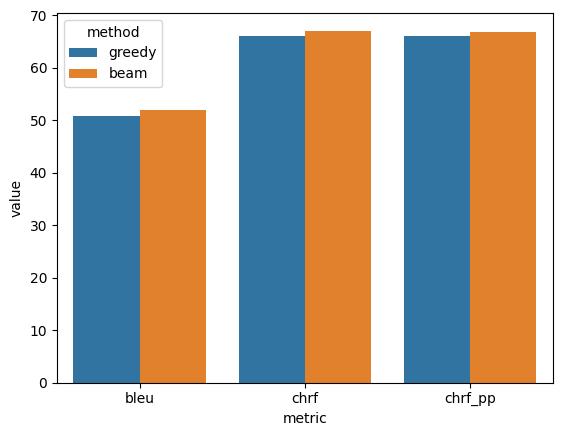

In [ ]:
greedy = evaluate(df["results_greedy"].tolist(), df["en_txt"].tolist())
beam = evaluate(df["results_beam"].tolist(), df["en_txt"].tolist())

records = []
for res, label in [(greedy, "greedy"), (beam, "beam")]:
    for key, value in dataclasses.asdict(res).items():
        rec = {"method": label, "metric": key, "value": value}
        records.append(rec)

df_metrics = pd.DataFrame().from_records(records)

sns.barplot(df_metrics, x="metric", y="value", hue="method")